### Our objective: robustify a given neural network 

##### Pending 
- Identify the layer required further improvement 

In [1]:
'''
0. Prepare for experiments 
    Current setting: CNN (before the third layer)
'''
%matplotlib inline
import property_inference_interface

meta_params = {
    'num_of_LPs': 4,
    'size_of_train_set': 1000,
    'size_of_test_set': 100,
    'flatten': False, 
    'model_type': 'CNN',
    'adv_attack': 'i_FGSM',
    'is_debug': False
}
PI = property_inference_interface.PropertyInferenceInterface(meta_params)
PI.load_model('MNIST_CNN.pt')
PI.set_dropout_rate(0)

//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [2]:
print('Evaluate accurancy: original')
dataset_type = 'train'
acc = PI.eval_model(dataset_type)
print('Model (', dataset_type, ') accurancy:', acc)

dataset_type = 'test'
acc = PI.eval_model(dataset_type)
print('Model (', dataset_type, ') accurancy:', acc)

Evaluate accurancy: original
Model ( train ) accurancy: 0.991
Model ( test ) accurancy: 0.98


In [3]:
import pickle
set_of_signatures = PI.generate_signatures()
fn_name = 'normal.txt'
with open(fn_name, "wb") as fp:   #Pickling
    pickle.dump(set_of_signatures, fp)
    
set_of_adv_i_FGSM_signatures = PI.generate_signatures(is_benign=False, type_of_attack='i_FGSM')
fn_name = 'i_FGSM_eps_0.50.txt'
with open(fn_name, "wb") as fp:   #Pickling
    pickle.dump(set_of_adv_i_FGSM_signatures, fp)
    
set_of_adv_JSMA_signatures = PI.generate_signatures(is_benign=False, type_of_attack='JSMA', eps=0.10)
fn_name = 'JSMA_eps_0.10.txt'
with open(fn_name, "wb") as fp:   #Pickling
    pickle.dump(set_of_adv_JSMA_signatures, fp)
    
# with open(fn_name, "wb") as fp:   #Pickling
#     pickle.dump(set_of_adv_signatures, fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Using TensorFlow backend.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [4]:
split_line = 500
train_set_of_signatures, test_set_of_signatures = set_of_signatures[:split_line], set_of_signatures[split_line:]
print(len(train_set_of_signatures), len(test_set_of_signatures), len(set_of_signatures))
train_set_of_adv_i_FGSM_signatures, test_set_of_adv_i_FGSM_signatures = set_of_adv_i_FGSM_signatures[:split_line], set_of_adv_i_FGSM_signatures[split_line:]
print(len(train_set_of_adv_i_FGSM_signatures), len(test_set_of_adv_i_FGSM_signatures), len(set_of_adv_i_FGSM_signatures))
train_set_of_adv_JSMA_signatures, test_set_of_adv_JSMA_signatures = set_of_adv_JSMA_signatures[:split_line], set_of_adv_JSMA_signatures[split_line:]
print(len(train_set_of_adv_JSMA_signatures), len(test_set_of_adv_JSMA_signatures), len(set_of_adv_JSMA_signatures))

500 500 1000
500 392 892
500 480 980


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch

class Guard(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        
        self.kernel_size = 1
        
        self.pre_l1_conv1 = nn.Conv2d(16, 8, 1)
        self.pre_l2_conv1 = nn.Conv2d(16, 8, 1)
        self.pre_l3_conv1 = nn.Conv2d(32, 8, 1)
        
        self.xh1 = nn.Conv2d(8, 8, 1)
        self.xh2 = nn.Conv2d(8, 8, 1)
        self.xh3 = nn.Conv2d(8, 8, 1)
        self.xh4 = nn.Linear(64, 64)
        
        self.hh12 = nn.Conv2d(8, 8, 15)
        self.hh23 = nn.Conv2d(8, 8, 8)
        self.hh34 = nn.Linear(8*3*3, 64)
        
        self.hy = nn.Linear(64, 2)

    def forward(self, f1, f2, f3, f4):
        x1 = self.relu(self.pre_l1_conv1(f1)) # 1, 8, 24, 24 
        x2 = self.relu(self.pre_l2_conv1(f2)) # 1, 8, 10, 10
        x3 = self.relu(self.pre_l3_conv1(f3)) # 1, 8, 3, 3
        x4 = f4.view(-1, 64) # 1, 64
        
        h1 = self.relu(self.xh1(x1))
        h2 = self.relu(torch.add(self.hh12(h1), self.xh2(x2)))
        h3 = self.relu(torch.add(self.hh23(h2), self.xh3(x3)))
        h3 = h3.view(-1, 8*3*3)
        h4 = self.relu(torch.add(self.hh34(h3), self.xh4(x4)))
        outputs = self.hy(h4)
        return outputs
        
    
def train_guard_model(guard_model, train_benign_dataset, train_adv_dataset_1, train_adv_dataset_2, epoches):
    X = train_benign_dataset
    X1_ = train_adv_dataset_1
    X2_ = train_adv_dataset_2
    loss_func, optimizer = nn.BCEWithLogitsLoss(), torch.optim.Adam(guard_model.parameters())

    accs, losses = [], []
    
    for epoch in range(epoches):
        total_loss = None 
        b_correct_count, a1_correct_count, a2_correct_count = 0, 0, 0
        for i in range(len(X)):
            x = X[i]
            f1 = torch.from_numpy(np.array(x[0])).float()
            f2 = torch.from_numpy(np.array(x[1])).float()
            f3 = torch.from_numpy(np.array(x[2])).float()
            f4 = np.expand_dims(x[3], axis=2)
            f4 = torch.from_numpy(f4).float()
            outputs = guard_model.forward(f1, f2, f3, f4)
            label = torch.from_numpy(np.array([[1, 0]])).float()

            loss = loss_func(outputs, label)
            if i == 0: total_loss = loss 
            else: total_loss += loss
                
            prediction = (outputs.max(1, keepdim=True)[1]).item()     
            if (prediction == 0): b_correct_count += 1
                
            # Optimization (back-propogation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        for i in range(len(X1_)):
            x = X1_[i]
            f1 = torch.from_numpy(np.array(x[0])).float()
            f2 = torch.from_numpy(np.array(x[1])).float()
            f3 = torch.from_numpy(np.array(x[2])).float()
            f4 = np.expand_dims(x[3], axis=2)
            f4 = torch.from_numpy(f4).float()
            outputs = guard_model.forward(f1, f2, f3, f4)
            label = torch.from_numpy(np.array([[0, 1]])).float()

            loss = loss_func(outputs, label)
            if i == 0: total_loss = loss 
            else: total_loss += loss
                
            prediction = (outputs.max(1, keepdim=True)[1]).item()     
            if (prediction == 1): a1_correct_count += 1

            # Optimization (back-propogation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        for i in range(len(X2_)):
            x = X2_[i]
            f1 = torch.from_numpy(np.array(x[0])).float()
            f2 = torch.from_numpy(np.array(x[1])).float()
            f3 = torch.from_numpy(np.array(x[2])).float()
            f4 = np.expand_dims(x[3], axis=2)
            f4 = torch.from_numpy(f4).float()
            outputs = guard_model.forward(f1, f2, f3, f4)
            label = torch.from_numpy(np.array([[0, 1]])).float()

            loss = loss_func(outputs, label)
            if i == 0: total_loss = loss 
            else: total_loss += loss
                
            prediction = (outputs.max(1, keepdim=True)[1]).item()     
            if (prediction == 1): a2_correct_count += 1

            # Optimization (back-propogation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        acc = (b_correct_count+a1_correct_count+a2_correct_count)/(len(X)+len(X1_)+len(X2_))
        print('epoch:', (epoch+1), 'loss:', total_loss)    
        print('benign correct:', b_correct_count, '/', len(X))
        print('adv (i_FGSM) correct:', a1_correct_count, '/', len(X1_))
        print('adv (JSMA) correct:', a2_correct_count, '/', len(X2_))
        print('acc:', acc)
        accs.append(acc)
        losses.append(total_loss)
        
    return accs, losses


guard_model = Guard()
guard_model.train()
epoches = 25
accs, losses = train_guard_model(guard_model, train_set_of_signatures, train_set_of_adv_i_FGSM_signatures, train_set_of_adv_JSMA_signatures, epoches)
losses = [x.item() for x in losses]
guard_model.eval()
# torch.save(guard_model, 'guard.pt')
# guard_model = torch.load('guard.pt')


epoch: 1 loss: tensor(0., grad_fn=<AddBackward0>)
benign correct: 496 / 500
adv (i_FGSM) correct: 492 / 500
adv (JSMA) correct: 500 / 500
acc: 0.992
epoch: 2 loss: tensor(2.3129, grad_fn=<AddBackward0>)
benign correct: 479 / 500
adv (i_FGSM) correct: 485 / 500
adv (JSMA) correct: 500 / 500
acc: 0.976
epoch: 3 loss: tensor(14.7806, grad_fn=<AddBackward0>)
benign correct: 436 / 500
adv (i_FGSM) correct: 480 / 500
adv (JSMA) correct: 500 / 500
acc: 0.944
epoch: 4 loss: tensor(18.4962, grad_fn=<AddBackward0>)
benign correct: 458 / 500
adv (i_FGSM) correct: 486 / 500
adv (JSMA) correct: 499 / 500
acc: 0.962
epoch: 5 loss: tensor(17.9045, grad_fn=<AddBackward0>)
benign correct: 463 / 500
adv (i_FGSM) correct: 488 / 500
adv (JSMA) correct: 497 / 500
acc: 0.9653333333333334
epoch: 6 loss: tensor(17.4147, grad_fn=<AddBackward0>)
benign correct: 463 / 500
adv (i_FGSM) correct: 487 / 500
adv (JSMA) correct: 494 / 500
acc: 0.9626666666666667
epoch: 7 loss: tensor(17.8616, grad_fn=<AddBackward0>)
b

Guard(
  (relu): ReLU()
  (pre_l1_conv1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (pre_l2_conv1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (pre_l3_conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (xh4): Linear(in_features=64, out_features=64, bias=True)
  (hh12): Conv2d(8, 8, kernel_size=(15, 15), stride=(1, 1))
  (hh23): Conv2d(8, 8, kernel_size=(8, 8), stride=(1, 1))
  (hh34): Linear(in_features=72, out_features=64, bias=True)
  (hy): Linear(in_features=64, out_features=2, bias=True)
)

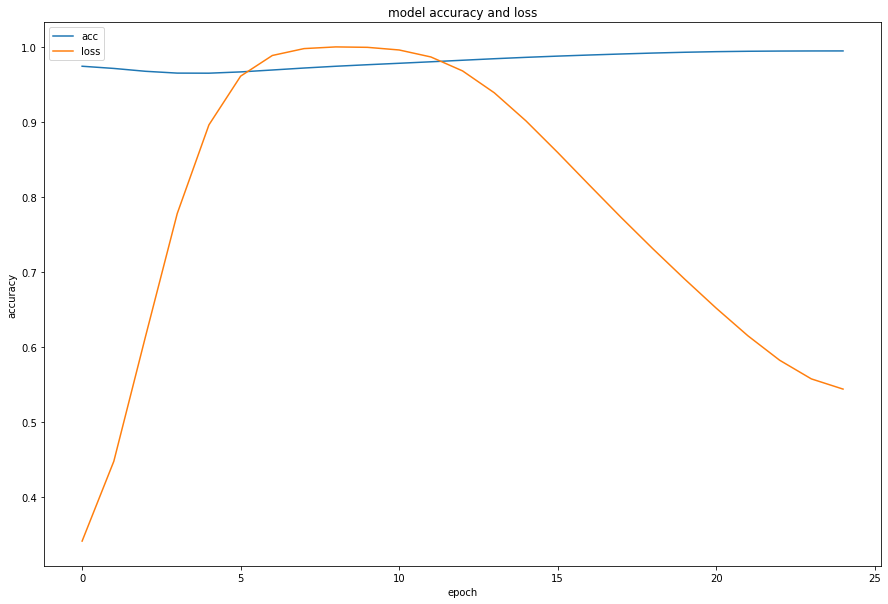

In [6]:
import copy
from scipy.ndimage.filters import gaussian_filter1d
smooth_accs = gaussian_filter1d(accs, sigma=2)
smooth_losses = gaussian_filter1d(losses, sigma=2)
norm_smooth_losses = [float(i)/max(smooth_losses) for i in smooth_losses]

from matplotlib import pyplot as plt
# declare a figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

# summarize history for accuracy
plt.plot(smooth_accs)
plt.plot(norm_smooth_losses)
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

In [7]:
def test_guard_model(guard_model, test_benign_dataset, test_adv_dataset_1, test_adv_dataset_2):
    X = test_benign_dataset
    X1_ = test_adv_dataset_1
    X2_ = test_adv_dataset_2

    b_correct_count, a1_correct_count, a2_correct_count = 0, 0, 0
    for i in range(len(X)):
        x = X[i]
        f1 = torch.from_numpy(np.array(x[0])).float()
        f2 = torch.from_numpy(np.array(x[1])).float()
        f3 = torch.from_numpy(np.array(x[2])).float()
        f4 = np.expand_dims(x[3], axis=2)
        f4 = torch.from_numpy(f4).float()
        outputs = guard_model.forward(f1, f2, f3, f4)
        label = torch.from_numpy(np.array([[1, 0]])).float()

        prediction = (outputs.max(1, keepdim=True)[1]).item()     
        if (prediction == 0): b_correct_count += 1

    for i in range(len(X1_)):
        x = X_[i]
        f1 = torch.from_numpy(np.array(x[0])).float()
        f2 = torch.from_numpy(np.array(x[1])).float()
        f3 = torch.from_numpy(np.array(x[2])).float()
        f4 = np.expand_dims(x[3], axis=2)
        f4 = torch.from_numpy(f4).float()
        outputs = guard_model.forward(f1, f2, f3, f4)
        label = torch.from_numpy(np.array([[0, 1]])).float()

        prediction = (outputs.max(1, keepdim=True)[1]).item()     
        if (prediction == 1): a1_correct_count += 1
            
    for i in range(len(X2_)):
        x = X_[i]
        f1 = torch.from_numpy(np.array(x[0])).float()
        f2 = torch.from_numpy(np.array(x[1])).float()
        f3 = torch.from_numpy(np.array(x[2])).float()
        f4 = np.expand_dims(x[3], axis=2)
        f4 = torch.from_numpy(f4).float()
        outputs = guard_model.forward(f1, f2, f3, f4)
        label = torch.from_numpy(np.array([[0, 1]])).float()

        prediction = (outputs.max(1, keepdim=True)[1]).item()     
        if (prediction == 1): a2_correct_count += 1

    acc = (b_correct_count+a_correct_count)/(len(X)+len(X_))
    print('benign correct:', b_correct_count, 'num of benign samples:', len(X))
    print('adv (i_FGSM) correct:', a1_correct_count, 'num of adv samples:', len(X1_))
    print('adv (JSMA) correct:', a2_correct_count, 'num of adv samples:', len(X2_))
    print('acc:', acc)

test_guard_model(guard_model, test_set_of_signatures, test_set_of_adv_i_FGSM_signatures, test_set_of_adv_JSMA_signatures)

SyntaxError: invalid token (<ipython-input-7-130d5348f143>, line 49)